# Experiment Tracking - MLFLow
Create a small lab using MLFlow to train and evaluate Logistic Regression and a PyTorch neural network on a synthetic dataset with two classes. Log model parameters, artifacts, and evaluation metrics (accuracy, precision, recall) using MLFlow. Perform hyperparameter optimization on learning rate, optimizer, and loss function. Finally, serve the model with the best recall using MLFlow.

In this lab we will look at
1. Tracking model experiment and its artifacts (by training Neural Network and Logistic Regression models on different hyperparameters)
2. Saving model to registry
3. Serving model and making predictions

## Install and import MLFlow and other dependencies.


In [1]:
# !pip install mlflow scikit-learn torch numpy
# python version used - 3.13

In [2]:
import mlflow
from mlflow.models import infer_signature
mlflow.autolog() 

## Generate synthetic data
Create a synthetic dataset with 2 input features X = [X1, X2] to perform Binary Classiciation.

2025/11/03 17:20:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Shape of X: (1000, 2)
Shape of y: (1000,)


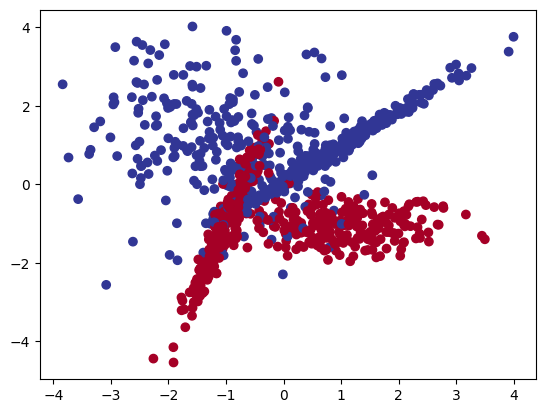

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=42)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# plot data
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

## Models to experiment
Define Logistic Regression and a PyTorch neural network models.


In [4]:
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn

# Define Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Define PyTorch neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Input layer (2 features) to hidden layer (16 neurons)
        self.relu = nn.ReLU()        # Activation function
        self.fc2 = nn.Linear(16, 1)  # Hidden layer to output layer (1 neuron for binary classification)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary output

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

nn_model = SimpleNN()

print("Logistic Regression model defined:")
print(lr_model)
print("\nPyTorch Neural Network model defined:")
print(nn_model)

Logistic Regression model defined:
LogisticRegression(random_state=42)

PyTorch Neural Network model defined:
SimpleNN(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Define Hyper-parameters


In [5]:
# Define hyperparameters for Logistic Regression
lr_param_grid = {
    'penalty': ['l1', 'l2'],             # Regularization penalty
    'C': [0.1, 1, 10, 100],  # Learning rate for the optimizer
}

# Define hyperparameters for PyTorch neural network
nn_param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 1],  # Learning rate for the optimizer
    'optimizer': ['Adam', 'SGD'],         # Optimizer type
}

print("Logistic Regression Hyperparameter Grid:")
print(lr_param_grid)
print("\nPyTorch Neural Network Hyperparameter Grid:")
print(nn_param_grid)

Logistic Regression Hyperparameter Grid:
{'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100]}

PyTorch Neural Network Hyperparameter Grid:
{'learning_rate': [0.001, 0.01, 0.1, 1], 'optimizer': ['Adam', 'SGD']}


## Model tracking - Training & Evaluation

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import itertools
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import numpy as np # Import numpy
from urllib.parse import urlparse


In [7]:
# Split the synthetic data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Add a dimension for BCEWithLogitsLoss
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) # Add a dimension for BCEWithLogitsLoss

### Trying different experiments with Logistic Regression

In [8]:
mlflow.set_experiment("Best Binary Classifier")
# Iterate through hyperparameter combinations
for lr_params in itertools.product(*lr_param_grid.values()):
    lr_param_dict = dict(zip(lr_param_grid.keys(), lr_params))

    # Create descriptive run name
    run_name = f"LR_penalty{lr_param_dict['penalty']}"

    with mlflow.start_run(nested=True, run_name=run_name):
        # Add tags for easier filtering
        mlflow.set_tags({
            "model_type": "LogisticRegression",
            "regularization": lr_param_dict['penalty'],
        })

        # Log parameters
        mlflow.log_params(lr_param_dict)

        # Train and evaluate
        lr = LogisticRegression(**lr_param_dict, solver='liblinear', random_state=42)
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        y_pred_train = lr.predict(X_train)
        signature = infer_signature(X_train, y_pred_train)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Log metrics
        accuracy_lr = accuracy_score(y_test, y_pred_lr)
        precision_lr = precision_score(y_test, y_pred_lr, zero_division=1)
        recall_lr = recall_score(y_test, y_pred_lr)

        mlflow.log_metric("test_accuracy", accuracy_lr)
        mlflow.log_metric("test_precision", precision_lr)
        mlflow.log_metric("test_recall", recall_lr)

        # Log model
        if tracking_url_type_store != "file":
        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.sklearn.log_model(
                lr, "LogisticRegressionModel", registered_model_name=run_name, signature=signature
            )
        else:
            mlflow.sklearn.log_model(lr, "LogisticRegressionModel", signature=signature)

2025/11/03 17:20:13 INFO mlflow.tracking.fluent: Experiment with name 'Best Binary Classifier' does not exist. Creating a new experiment.
2025/11/03 17:20:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


### Let's say i run another model on another day. (or my colleague is working on another model)

In [9]:
mlflow.set_experiment("Best Binary Classifier")
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Enable autologging for PyTorch
mlflow.pytorch.autolog(log_datasets=True)

for nn_params in itertools.product(*nn_param_grid.values()):
    nn_param_dict = dict(zip(nn_param_grid.keys(), nn_params))

    # Create descriptive run name
    run_name = f"NN_{nn_param_dict['optimizer']}_lr{nn_param_dict['learning_rate']}"

    with mlflow.start_run(nested=True, run_name=run_name):
        # Add tags for easier filtering
        mlflow.set_tags({
            "model_type": "NeuralNetwork",
            "optimizer": nn_param_dict['optimizer'],
            "loss_function": 'BCELoss'
        })

        # Train the PyTorch neural network model
        nn_model = SimpleNN()
        learning_rate = nn_param_dict['learning_rate']
        optimizer_type = nn_param_dict['optimizer']
        
        if optimizer_type == 'Adam':
            optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)
        elif optimizer_type == 'SGD':
            optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate)
        else:
            raise ValueError("Unsupported optimizer")

        criterion = torch.nn.BCELoss()

        epochs = 12

        # Track training progress
        for epoch in range(epochs):
            nn_model.train()
            epoch_loss = 0.0
            batches = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = nn_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                batches += 1

            # Log training loss every epoch
            avg_loss = epoch_loss / batches
            mlflow.log_metric("training_loss", avg_loss, step=epoch)

        # Evaluate and log metrics
        nn_model.eval()
        with torch.no_grad():
            y_pred_tensor_nn = nn_model(X_test_tensor)
            y_pred_train = nn_model(X_train_tensor)
            y_pred_train_numpy = y_pred_train.numpy()
            y_pred_nn = (y_pred_tensor_nn > 0.5).int().numpy()

        # Log input/output examples to help MLflow understand the data
        signature = infer_signature(
            X_train_tensor.numpy(), 
            y_pred_train_numpy
        )

        mlflow.log_params(nn_param_dict)

        accuracy_nn = accuracy_score(y_test_tensor, y_pred_nn)
        precision_nn = precision_score(y_test_tensor, y_pred_nn, zero_division=1)
        recall_nn = recall_score(y_test_tensor, y_pred_nn)

        mlflow.log_metric("test_accuracy", accuracy_nn)
        mlflow.log_metric("test_precision", precision_nn)
        mlflow.log_metric("test_recall", recall_nn)
        
        # Log model - Make sure to include input_example for dataset capture
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        if tracking_url_type_store != "file":
            mlflow.pytorch.log_model(
                nn_model, 
                artifact_path="NeuralNetworkModel", 
                registered_model_name=run_name,
                signature=signature
            )
        else:
            mlflow.pytorch.log_model(
                nn_model, 
                "NeuralNetworkModel", 
                signature=signature
            )
        
        # Log the data explicitly as an artifact as a backup
        mlflow.log_dict(
            {
                "dataset_info": {
                    "training_samples": X_train.shape[0],
                    "test_samples": X_test.shape[0], 
                    "features": X_train.shape[1],
                    "class_distribution": np.bincount(y).tolist()
                }
            }, 
            "dataset_info.json"
        )

2025/11/03 17:20:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:20:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:21:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:21:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/03 17:21:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


## On a terminal run
`mlflow ui`

You can see the experiment 'Best Binary Clasifier'

## Let's get model with the best recall on test set

In [13]:
# Get the model with best recall and serve it for prediction
from mlflow.tracking import MlflowClient

# Set the experiment name to match what you used during training
experiment_name = "Best Binary Classifier"

# Get the experiment ID
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)
if experiment is None:
    print(f"Experiment '{experiment_name}' not found.")
    exit(1)

experiment_id = experiment.experiment_id
print(f"Found experiment '{experiment_name}' with ID: {experiment_id}")

# Get all runs for this experiment
runs = client.search_runs(
    experiment_ids=experiment_id,
    filter_string="",
    order_by=["metrics.test_recall DESC"]  # Order by recall in descending order
)

if not runs:
    print("No runs found for this experiment.")
    exit(1)

# Get the run with the highest recall
best_run = runs[0]
best_recall = best_run.data.metrics.get("test_recall", 0)
best_run_id = best_run.info.run_id

print(f"Best Run ID: {best_run_id}")
print(f"Highest recall: {best_recall:.4f}")

# Print all parameters of the best run
print("\nBest Model Parameters:")
for param_key, param_value in best_run.data.params.items():
    print(f"  {param_key}: {param_value}")

# Get model tags
print("\nModel Tags:")
for tag_key, tag_value in best_run.data.tags.items():
    # Filter out system tags
    if not tag_key.startswith("mlflow."):
        print(f"  {tag_key}: {tag_value}")

Found experiment 'Best Binary Classifier' with ID: 104704461691011141
Best Run ID: 138e4c01cedb43e0b93a480ddb1b508d
Highest recall: 0.9091

Best Model Parameters:
  optimizer: SGD
  learning_rate: 1

Model Tags:
  loss_function: BCELoss
  optimizer: SGD
  model_type: NeuralNetwork


## Load model and make prediction

In [16]:
model_type = None
for tag_key, tag_value in best_run.data.tags.items():
    if tag_key == "model_type":
        model_type = tag_value
        break

print(f"\nBest model type: {model_type}")

# Load the model based on its type
model_path = f"runs:/{best_run_id}"
if model_type == "LogisticRegression":
    model_path += "/LogisticRegressionModel"
    model = mlflow.sklearn.load_model(model_path)
    print("Loaded LogisticRegression model")
elif model_type == "NeuralNetwork":
    model_path += "/NeuralNetworkModel"
    model = mlflow.pytorch.load_model(model_path)
    print("Loaded PyTorch Neural Network model")
else:
    print(f"Unknown model type: {model_type}")
    exit(1)

sample_input = np.array([
    [0.5, 0.5],   # Sample 1
    [-0.5, 0.8],  # Sample 2
    [1.2, -0.5],  # Sample 3
    [-1.0, -1.0]  # Sample 4
])

print("\nSample input shape:", sample_input.shape)

# Convert to tensor if needed for PyTorch model
if model_type == "NeuralNetwork":
    import torch
    sample_input_tensor = torch.tensor(sample_input, dtype=torch.float32)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(sample_input_tensor)
        predictions = (outputs > 0.5).int().numpy()
    
    # Print prediction    
    print("\nPredictions:")
    for i, pred in enumerate(predictions):
        print(f"  Sample {i+1}: X = {sample_input[i]} || Prediction: {pred[0]}")
else:
    # For scikit-learn models
    probabilities = model.predict_proba(sample_input)
    predictions = model.predict(sample_input)
    
    # Print predictions
    print("\nPredictions:")
    for i, pred in enumerate(predictions):
        print(f"  Sample {i+1}: X = {sample_input[i]} || Prediction: {pred}")


Best model type: NeuralNetwork
Loaded PyTorch Neural Network model

Sample input shape: (4, 2)

Predictions:
  Sample 1: X = [0.5 0.5] || Prediction: 1
  Sample 2: X = [-0.5  0.8] || Prediction: 1
  Sample 3: X = [ 1.2 -0.5] || Prediction: 0
  Sample 4: X = [-1. -1.] || Prediction: 0


## Serve Model

In [17]:
# Construct the model URI
if model_type == "LogisticRegression":
    model_uri = f"runs:/{best_run_id}/LogisticRegressionModel"
elif model_type == "NeuralNetwork":
    model_uri = f"runs:/{best_run_id}/NeuralNetworkModel"
else:
    print(f"Unknown model type: {model_type}")
    exit(1)

model_uri

'runs:/138e4c01cedb43e0b93a480ddb1b508d/NeuralNetworkModel'

In [19]:
# Create output directory if it doesn't exist
import os
output_dir = "best_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"\nSaving model from {model_uri} to {output_dir}...")

# Step 2: Save the model locally based on its type
try:
    if model_type == "LogisticRegression":
        # Load and save scikit-learn model
        model = mlflow.sklearn.load_model(model_uri)
        mlflow.sklearn.save_model(model, output_dir)
    elif model_type == "NeuralNetwork":
        # Load and save PyTorch model
        model = mlflow.pytorch.load_model(model_uri)
        mlflow.pytorch.save_model(model, output_dir)
    
    print(f"Model saved successfully to: {output_dir}")
except Exception as e:
    print(f"Error saving model: {e}")


Saving model from runs:/138e4c01cedb43e0b93a480ddb1b508d/NeuralNetworkModel to best_model...
Model saved successfully to: best_model


On a terminal window (new window) run the following (use the model uri and run_id from above)

`mlflow models serve -m <best_model_path> -p 5001 --no-conda`

example

`mlflow models serve -m /Users/rjaditya/Documents/NEU-SEM/Fall-25/MLOps/MLOPS_rjaditya/LAB4/best_model -p 5001 --no-conda`

if you get port availability error, run `mlops_free_port.sh` to find the next free port

The above command will start a server on your system. We have pulled the model with the highest recall and will be using that model to test

### Test served model

In [21]:
import requests
import json

# Load test data
with open('test_input.json', 'r') as f:
    test_data = json.load(f)

# Make a prediction request
response = requests.post(
    "http://localhost:5001/invocations",
    data=json.dumps(test_data),
    headers={"Content-Type": "application/json"}
)

# Check the response
if response.status_code == 200:
    print("Success!")
    print("Predictions:", response.json())
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Success!
Predictions: {'predictions': [{'0': 0.967242956161499}, {'0': 0.5590434670448303}, {'0': 0.16613692045211792}]}
